In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from numba import njit

In [38]:
@njit
def locate_point_in_lattice(point, a1, a2, origin_centered):
    """
    Locate where a point falls in the lattice.
    
    Parameters:
    -----------
    point : numpy.ndarray
        The (x, y) coordinates of the point
    a1, a2 : numpy.ndarray
        The two basis vectors defining the lattice
    origin_centered : bool
        If True, the first unit cell is centered at the origin
        
    Returns:
    --------
    cell_indices : tuple
        The indices (i, j) of the unit cell containing the point
    fractional_coords : numpy.ndarray
        The fractional coordinates within the unit cell (values between 0 and 1)
    cell_center : numpy.ndarray
        The (x, y) coordinates of the center of the identified unit cell
    """
    # Calculate reciprocal vectors (inlined)
    det = a1[0] * a2[1] - a1[1] * a2[0]
    b1 = np.array([a2[1], -a2[0]]) / det
    b2 = np.array([-a1[1], a1[0]]) / det
    
    # Calculate offset (inlined)
    offset = -0.5 * (a1 + a2) if origin_centered else np.zeros(2)
    
    # Adjust point if lattice is centered
    adjusted_point = point - offset
    
    # Calculate fractional coordinates using dot products with reciprocal lattice vectors
    frac_1 = adjusted_point[0] * b1[0] + adjusted_point[1] * b1[1]
    frac_2 = adjusted_point[0] * b2[0] + adjusted_point[1] * b2[1]
    
    # Get the cell indices by flooring the fractional coordinates
    i = int(np.floor(frac_1))
    j = int(np.floor(frac_2))
    
    # Calculate the fractional position within the unit cell
    frac_coords = np.array([frac_1 - i, frac_2 - j])

    # Calculate the position within the unit cell relative to bottom-left corner
    corner_frac_coords = np.array([frac_1 - i, frac_2 - j])
    
    # Convert to coordinates relative to cell center (-0.5 to 0.5 in each dimension)
    # This makes the center of the cell (0,0)
    center_frac_coords = corner_frac_coords - 0.5
    
    # Calculate the center of the identified unit cell
    cell_center = i * a1 + j * a2 + offset + 0.5 * (a1 + a2)

    center_coords = center_frac_coords*a1 + center_frac_coords*a2
    
    return (i, j), center_coords, cell_center

@njit
def generate_lattice_points(a1, a2, offset, n_cells_x, n_cells_y):
    """
    Generate lattice points for a given number of unit cells.
    
    Parameters:
    -----------
    a1, a2 : numpy.ndarray
        The two basis vectors defining the lattice
    offset : numpy.ndarray
        The offset vector
    n_cells_x, n_cells_y : int
        The number of unit cells in the x and y directions
    
    Returns:
    --------
    points : numpy.ndarray
        Array of lattice points with shape (n_cells_x * n_cells_y, 2)
    indices : numpy.ndarray
        Array of indices (i, j) for each point with shape (n_cells_x * n_cells_y, 2)
    """
    points = np.zeros((n_cells_x * n_cells_y, 2))
    indices = np.zeros((n_cells_x * n_cells_y, 2), dtype=np.int32)
    
    idx = 0
    for i in range(n_cells_x):
        for j in range(n_cells_y):
            points[idx] = i * a1 + j * a2 + offset
            indices[idx, 0] = i
            indices[idx, 1] = j
            idx += 1
    
    return points, indices


class Lattice2DPlotter:
    """
    A class for plotting 2D lattices that wraps around the jitted core functions.
    """
    def __init__(self, a1, a2, origin_centered=True):
        """
        Initialize a 2D lattice plotter with two basis vectors.
        
        Parameters:
        -----------
        a1, a2 : numpy.ndarray
            The two basis vectors defining the lattice
        origin_centered : bool, optional
            If True, the first unit cell is centered at the origin.
            If False, the corner between unit cells is at the origin.
        """
        self.a1 = np.array(a1, dtype=float)
        self.a2 = np.array(a2, dtype=float)
        self.origin_centered = origin_centered
        
        # Calculate offset (inlined)
        self.offset = -0.5 * (self.a1 + self.a2) if origin_centered else np.zeros(2)
        
        # Calculate reciprocal vectors (inlined)
        det = self.a1[0] * self.a2[1] - self.a1[1] * self.a2[0]
        self.b1 = np.array([self.a2[1], -self.a2[0]]) / det
        self.b2 = np.array([-self.a1[1], self.a1[0]]) / det
    
    def locate_point(self, point):
        """
        Wrapper around the jitted locate_point_in_lattice function.
        
        Returns:
        --------
        cell_indices : tuple
            The indices (i, j) of the unit cell containing the point
        fractional_coords : numpy.ndarray
            The fractional coordinates within the unit cell (values between 0 and 1)
        cell_center : numpy.ndarray
            The (x, y) coordinates of the center of the identified unit cell
        """
        return locate_point_in_lattice(
            np.array(point, dtype=float), 
            self.a1, 
            self.a2, 
            self.origin_centered
        )
    
    def plot_lattice(self, n_cells_x, n_cells_y, highlight_point=None, figsize=(10, 10)):
        """
        Plot the lattice with unit cells and optionally highlight a point.
        
        Parameters:
        -----------
        n_cells_x, n_cells_y : int
            The number of unit cells in the x and y directions
        highlight_point : tuple or numpy.ndarray, optional
            An (x, y) point to highlight on the plot
        figsize : tuple, optional
            Figure size
            
        Returns:
        --------
        fig, ax : matplotlib Figure and Axes objects
        """
        fig, ax = plt.subplots(figsize=figsize)
        
        # Generate lattice points using the jitted function
        points, indices = generate_lattice_points(
            self.a1, 
            self.a2, 
            self.offset, 
            n_cells_x, 
            n_cells_y
        )
        
        # Plot lattice points
        ax.scatter(points[:, 0], points[:, 1], c='blue', s=50, zorder=3)
        
        # Draw unit cells
        patches = []
        for i in range(n_cells_x):
            for j in range(n_cells_y):
                # Calculate vertices of the unit cell
                origin = i * self.a1 + j * self.a2 + self.offset
                vertices = [
                    origin,
                    origin + self.a1,
                    origin + self.a1 + self.a2,
                    origin + self.a2
                ]
                patches.append(Polygon(vertices, True))
        
        p = PatchCollection(patches, alpha=0.2, edgecolor='black')
        ax.add_collection(p)
        
        # Highlight the specified point if provided
        if highlight_point is not None:
            point = np.array(highlight_point)
            ax.scatter(point[0], point[1], c='red', s=100, zorder=4)
            
            # Find the unit cell, fractional coordinates, and cell center
            (i, j), frac_coords, cell_center = self.locate_point(point)
            
            # Add text to show the cell indices, fractional coordinates, and cell center
            ax.text(point[0], point[1] + 0.1, 
                   f"Cell: ({i}, {j})\nFrac: ({frac_coords[0]:.2f}, {frac_coords[1]:.2f})\nCenter: ({cell_center[0]:.2f}, {cell_center[1]:.2f})",
                   horizontalalignment='center', verticalalignment='bottom')
            
            # Mark the cell center
            ax.scatter(cell_center[0], cell_center[1], c='purple', s=80, zorder=4, marker='x')
            
            # Highlight the cell containing the point
            cell_origin = i * self.a1 + j * self.a2 + self.offset
            cell_vertices = [
                cell_origin,
                cell_origin + self.a1,
                cell_origin + self.a1 + self.a2,
                cell_origin + self.a2
            ]
            ax.add_patch(Polygon(cell_vertices, True, alpha=0.4, edgecolor='red', facecolor='yellow'))
        
        # Add basis vectors
        ax.arrow(0, 0, self.a1[0], self.a1[1], head_width=0.1, head_length=0.1, fc='green', ec='green', zorder=5)
        ax.arrow(0, 0, self.a2[0], self.a2[1], head_width=0.1, head_length=0.1, fc='green', ec='green', zorder=5)
        ax.text(self.a1[0]/2, self.a1[1]/2, "a₁", color='green', fontsize=12, ha='center', va='center')
        ax.text(self.a2[0]/2, self.a2[1]/2, "a₂", color='green', fontsize=12, ha='center', va='center')
        
        # Add grid lines
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Set equal aspect ratio
        ax.set_aspect('equal')
        
        # Add title and labels
        title = "2D Lattice"
        if self.origin_centered:
            title += " (Origin Centered)"
        else:
            title += " (Corner at Origin)"
        ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        # Add a marker at the origin
        ax.scatter([0], [0], c='black', marker='+', s=100, zorder=4)
        ax.text(0, 0, "  Origin", verticalalignment='center')
        
        plt.tight_layout()
        return fig, ax



Centered Lattice:
  Point [2.5 1.8] is in cell (3, 2)
  Fractional coordinates: [-0.5 -0.2]
  Cell center coordinates: [3. 2.]

Corner Lattice:
  Point [2.5 1.8] is in cell (2, 1)
  Fractional coordinates: [0.  0.3]
  Cell center coordinates: [2.5 1.5]



C:\Users\simonlab\AppData\Local\Temp\ipykernel_49384\135480128.py:186: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches.append(Polygon(vertices, True))
C:\Users\simonlab\AppData\Local\Temp\ipykernel_49384\135480128.py:215: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Polygon(cell_vertices, True, alpha=0.4, edgecolor='red', facecolor='yellow'))


Text(0.5, 1.0, 'Rectangular Lattice (Corner at Origin)')

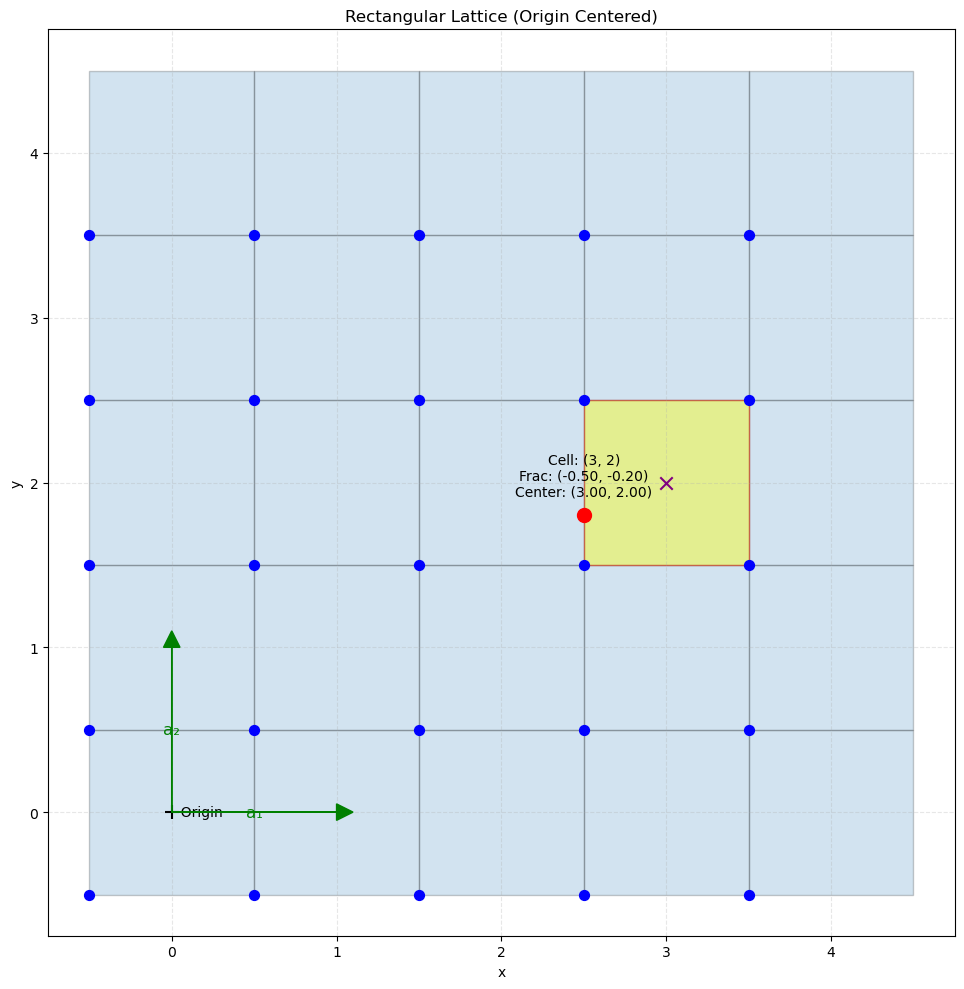

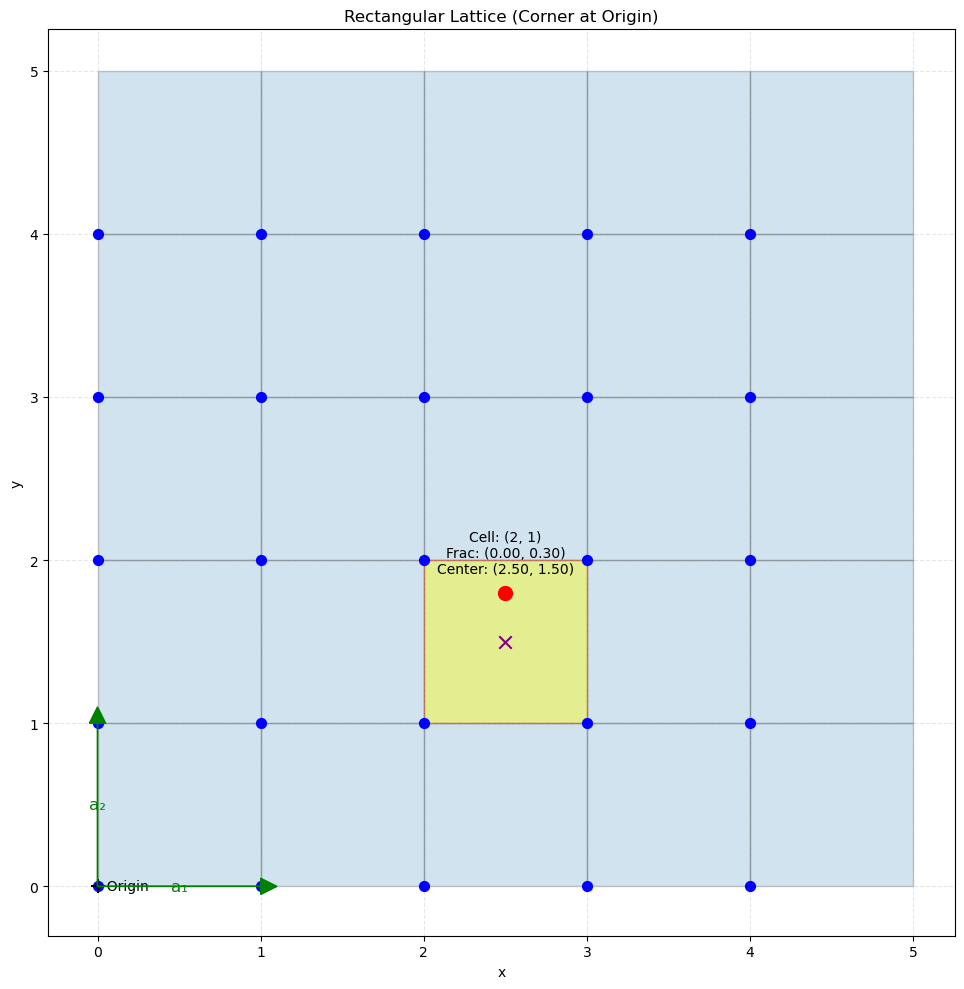

In [39]:
# Define basis vectors for a rectangular lattice
# a1 = np.array([1.0, 0.0])
# a2 = np.array([0.0, 1.0])

a1 = np.array([1.0, 0.0])
a2 = np.array([0.0, 1.0])

# Create lattice plotter with origin at the center of the first unit cell
lattice_centered = Lattice2DPlotter(a1, a2, origin_centered=True)

# Create lattice plotter with origin at the corner
lattice_corner = Lattice2DPlotter(a1, a2, origin_centered=False)

# Generate plots
# point_to_locate = np.array([1.7, 0.8])

point_to_locate = np.array([2.5, 1.8])



# Print information about the located point
for lattice, name in [(lattice_centered, "Centered"), (lattice_corner, "Corner")]:
    cell_indices, frac_coords, cell_center = lattice.locate_point(point_to_locate)
    print(f"{name} Lattice:")
    print(f"  Point {point_to_locate} is in cell {cell_indices}")
    print(f"  Fractional coordinates: {frac_coords}")
    print(f"  Cell center coordinates: {cell_center}")
    print()

lattice_centered.plot_lattice(5, 5, highlight_point=point_to_locate)
plt.title("Rectangular Lattice (Origin Centered)")

lattice_corner.plot_lattice(5, 5, highlight_point=point_to_locate)
plt.title("Rectangular Lattice (Corner at Origin)")

C:\Users\simonlab\AppData\Local\Temp\ipykernel_49384\135480128.py:186: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches.append(Polygon(vertices, True))
C:\Users\simonlab\AppData\Local\Temp\ipykernel_49384\135480128.py:215: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Polygon(cell_vertices, True, alpha=0.4, edgecolor='red', facecolor='yellow'))


Centered Lattice:
  Point [0.5  0.97] is in cell (0, 1)
  Fractional coordinates: [-0.09004464  0.1039746 ]
  Cell center coordinates: [0.5       0.8660254]

Corner Lattice:
  Point [0.5  0.97] is in cell (-1, 1)
  Fractional coordinates: [ 0.65995536 -0.32903811]
  Cell center coordinates: [0.25       1.29903811]



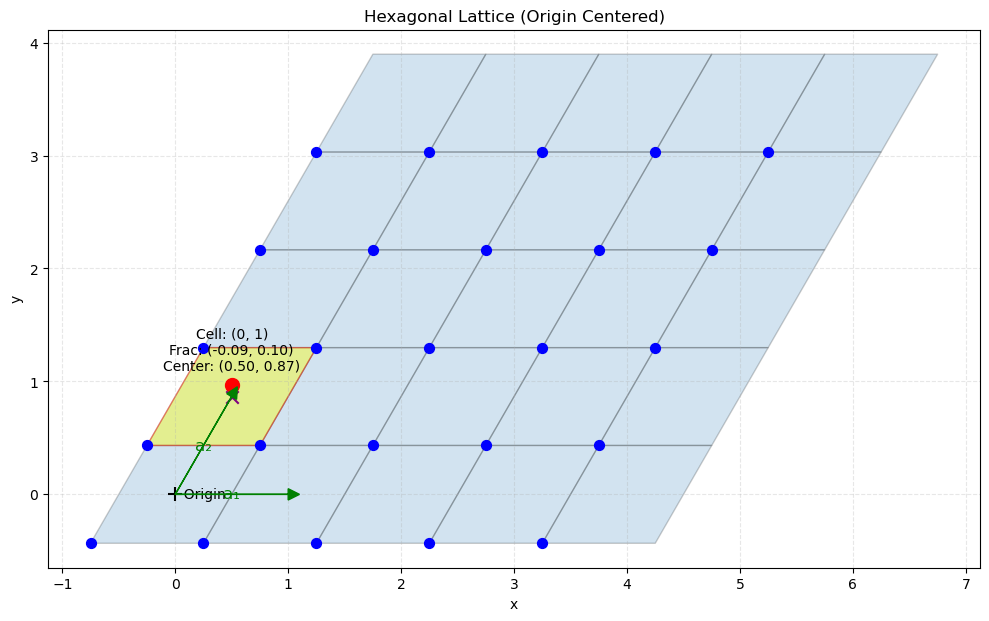

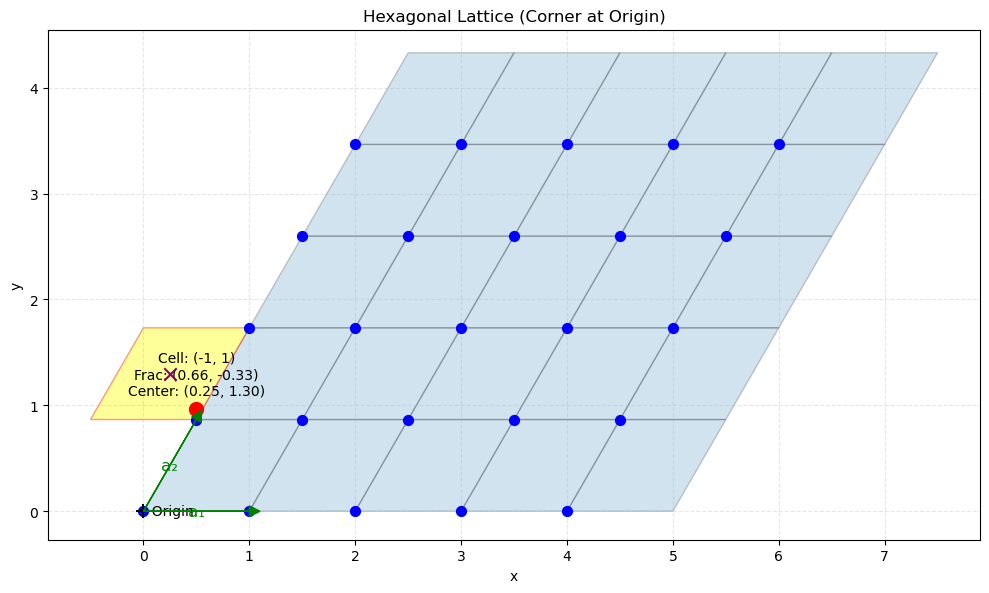

In [41]:

# Define basis vectors for a hexagonal lattice
a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, np.sqrt(3)/2])

# Create lattice plotter with origin at the center of the first unit cell
lattice_centered = Lattice2DPlotter(a1, a2, origin_centered=True)

# Create lattice plotter with origin at the corner
lattice_corner = Lattice2DPlotter(a1, a2, origin_centered=False)

# Generate plots
point_to_locate = np.array([0.5, 0.87+0.1])

lattice_centered.plot_lattice(5, 5, highlight_point=point_to_locate)
plt.title("Hexagonal Lattice (Origin Centered)")

lattice_corner.plot_lattice(5, 5, highlight_point=point_to_locate)
plt.title("Hexagonal Lattice (Corner at Origin)")

# Print information about the located point
for lattice, name in [(lattice_centered, "Centered"), (lattice_corner, "Corner")]:
    cell_indices, frac_coords, cell_center = lattice.locate_point(point_to_locate)
    print(f"{name} Lattice:")
    print(f"  Point {point_to_locate} is in cell {cell_indices}")
    print(f"  Fractional coordinates: {frac_coords}")
    print(f"  Cell center coordinates: {cell_center}")
    print()